In [1]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from typing import TypeVar
from pylab import rcParams
from itertools import product
import warnings

warnings.filterwarnings('ignore')
PandasDataFrame = TypeVar('pandas.core.frame.DataFrame')
PandasSeries = TypeVar('pandas.core.series.Series')
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="darkgrid")

#Функция для обращения отрицательных прогнозов в 0
def positiv(x: int) -> int:
    if x < 0:
        return 0
    else:
        return x


#Функция для обособления данных об одном регионе в отдельный фрейм и объединения всех покупок в данном регионе по часам
def get_region_data(data: PandasDataFrame, region: str) -> PandasDataFrame:
    data_reg = data[data['region'] == region]
    data_reg = data_reg.drop(['region'], axis=1)
    data_reg = data_reg.resample('1H').sum()
    
    g = sns.lineplot(data = data_reg);
    
    return data_reg


#Функция которая фитит модель и отрисовывает предсказания, фит, и существующий временной ряд, также возвращает прогноз    
def fit_and_show_results(model, period: int) -> PandasSeries:
    model_fit = model.fit()
    
    fc = model_fit.forecast(period, alpha=0.05)
    fc = fc.apply(round)
    fc = fc.apply(positiv)
    
    p = sns.lineplot(data=model_fit.predict(),color='g', label='Fitted quantity')
    p = sns.lineplot(data=fc, color='r', label='Predicted quantity')
    p = sns.lineplot(data=df_reg, color='b')
    p.set(xlabel="Date", ylabel='Quantiti');
    plt.show()
    
    return fc


In [2]:
df = pd.read_csv(r'..\data\dataset.csv', index_col=['local_date'], parse_dates=['local_date'])

df = df.drop(['Unnamed: 0'], axis=1)
df = df[df['barcode'] == '2000000000008']
df = df.drop(['barcode'], axis = 1)
df = df.drop(['item_id', 'receipt_id'], axis=1)
df = df[df['price'] <= df['price'].quantile(0.99)]
df = df[df['quantity'] <= df['quantity'].quantile(0.99)]
df['quantity'] = df['quantity'].apply(round)
df = df[df['quantity'] > 0]
df = df.rename(columns = {'quantity': 'Real quantity'})
df = df.drop(['device_id', 'price'], axis=1)
df = df.sort_index()

regions = list(df['region'].value_counts().index)


ARIMA(24, 0, 1)


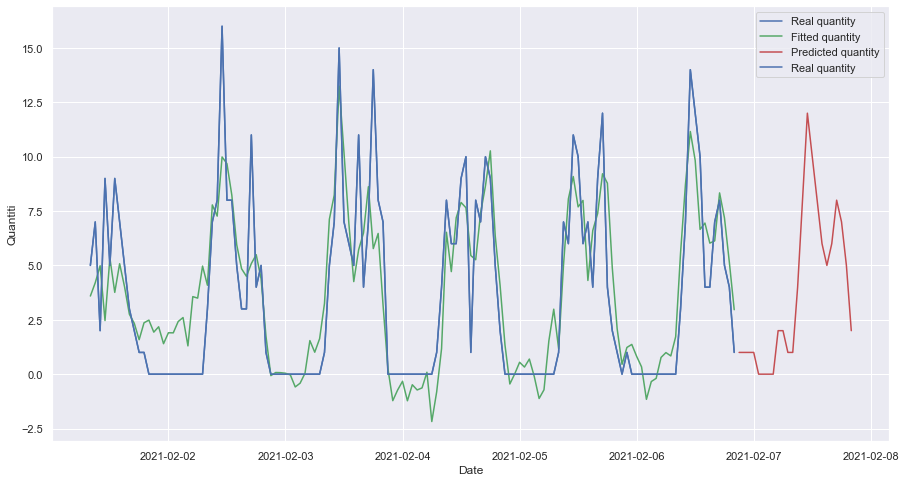

SARIMA(1, 0, 1)x(1, 1, 1, 24)


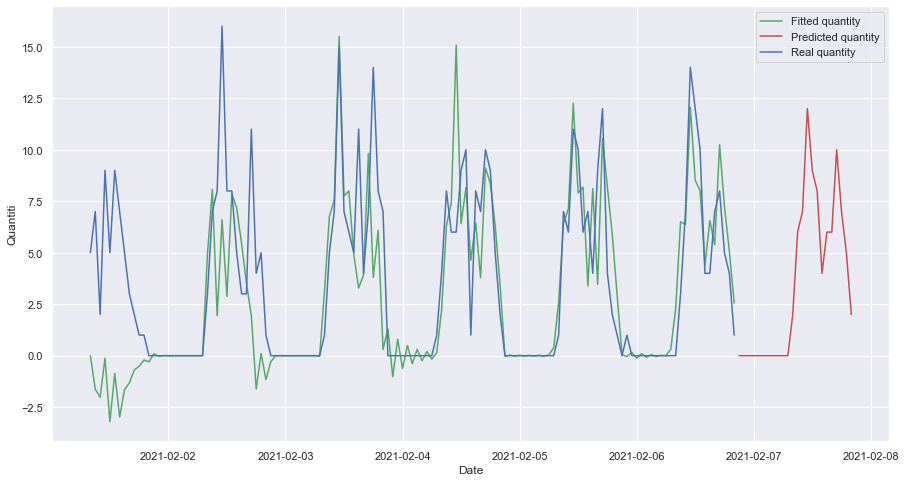

SARIMA(0, 1, 1)x(1, 1, 1, 24)


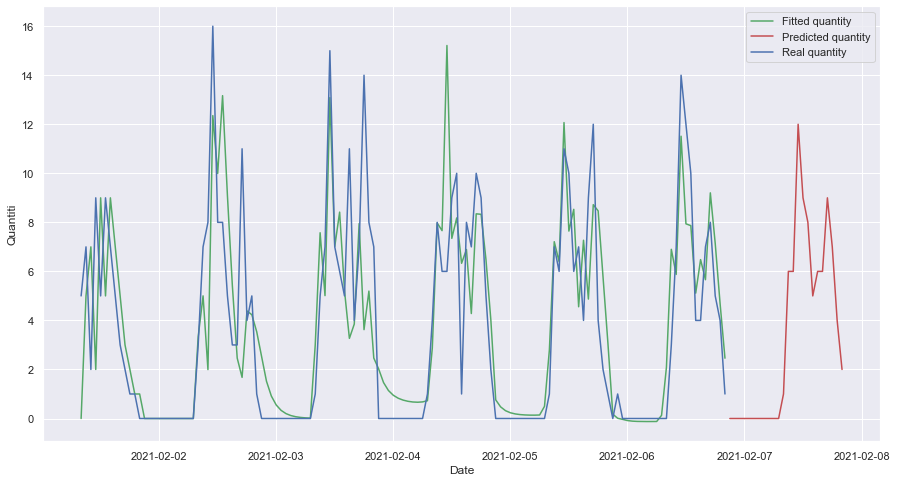

Республика Башкортостан


2021-02-06 21:00:00     0.0
2021-02-06 22:00:00     0.0
2021-02-06 23:00:00     0.0
2021-02-07 00:00:00     0.0
2021-02-07 01:00:00     0.0
2021-02-07 02:00:00     0.0
2021-02-07 03:00:00     0.0
2021-02-07 04:00:00     0.0
2021-02-07 05:00:00     1.0
2021-02-07 06:00:00     1.0
2021-02-07 07:00:00     0.0
2021-02-07 08:00:00     1.0
2021-02-07 09:00:00     5.0
2021-02-07 10:00:00     7.0
2021-02-07 11:00:00    12.0
2021-02-07 12:00:00     9.0
2021-02-07 13:00:00     8.0
2021-02-07 14:00:00     5.0
2021-02-07 15:00:00     6.0
2021-02-07 16:00:00     6.0
2021-02-07 17:00:00     9.0
2021-02-07 18:00:00     7.0
2021-02-07 19:00:00     5.0
2021-02-07 20:00:00     2.0
Freq: H, Name: predicted_mean, dtype: float64

In [3]:
#Меняя индекс получим предсказания для разных регионов
#Индекс для региона принимает значения от 0 до 60
region_index = 1

df = df[(pd.DatetimeIndex(df.index).year == 2021) &
        (pd.DatetimeIndex(df.index).month == 2)]
df_reg = get_region_data(df, regions[region_index])

param_analitics = (24, 0 ,1)
param_seasonal_for_min_aic = (1, 1, 1, 24)
param_min_aic = (0, 1, 1)
param_analitics_2 = (1, 0 ,1)

model_ARIMA_anal = ARIMA(df_reg, 
                         order=param_analitics, 
                         enforce_stationarity=False,
                         enforce_invertibility=False) 

print(f'ARIMA{param_analitics}') 
res_ARIMA_anal = fit_and_show_results(model_ARIMA_anal, 24)

model_SARIMA_anal = sm.tsa.statespace.SARIMAX(df_reg,
                                              order=param_analitics_2,
                                              seasonal_order=param_seasonal_for_min_aic,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)

print(f'SARIMA{param_analitics_2}x{param_seasonal_for_min_aic}')
res_SARIMA_anal = fit_and_show_results(model_SARIMA_anal, 24)

model_SARIMA = sm.tsa.statespace.SARIMAX(df_reg,
                                         order=param_min_aic,
                                         seasonal_order=param_seasonal_for_min_aic,
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)

print(f'SARIMA{param_min_aic}x{param_seasonal_for_min_aic}')
res_SARIMA = fit_and_show_results(model_SARIMA, 24)

print(regions[region_index])
(round((res_SARIMA + res_SARIMA_anal + res_ARIMA_anal)/3))
